In [1]:
import pandas as pd
from typing import Optional, List, Tuple
import os

os.environ['TOKENIZERS_PARALLELISM'] = 'false' # do not use multiprocessing to avoid the paralelism problem
pd.set_option("display.max_colwidth", None)  # this will be helpful when visualizing retriever outputs

### 0. Load dataset

In [2]:
from langchain.document_loaders import UnstructuredFileLoader

RAW_KNOWLEDGE_BASE = UnstructuredFileLoader("./docs/hobbitultrashort.txt").load()

### 1. Retriever - embeddings
<p>The retriever acts like an internal search engine: given the user query, it returns a few relevant snippets from your knowledge base. These snippets will then be fed to the Reader Model to help it generate its answer.</p>

#### 1.1 Split the documents into chunks

<i>Many options exist for text splitting: splitting on words, on sentence boundaries, recursive chunking that processes documents in a tree-like way to preserve structure information…</i>

- <b>Recursive chunking</b> breaks down the text into smaller parts step by step using a given list of separators sorted from the most important to the least important separator. <br>
For instance with the list of separators ["\n\n", "\n", ".", ""]

We also keep in mind that before we split the documents into chuncks we have to embed the documents and it could be a problem that the chunk lengths are not aligned with our limit maximum sequence length of the embedding model. </br>
<b>So we should make sure that our chunck sizes are below this limit, because any longer chunk will be trucated before processing, thus losing relevancy.</b>

In [ ]:
from sentence_transformers import SentenceTransformer

EMBED_MODEL_NAME = 'thenlper/gte-small'

# To get the value of the max sequence_length, we will query the underlying `SentenceTransformer` object used in the RecursiveCharacterTextSplitter: 512.
print(f"Model's maximum sequence length: {SentenceTransformer(EMBED_MODEL_NAME).max_seq_length}")

Now that we already know the maximum length of the embedding model we can create a RecursiveCharacterTextSplitter to count length in number of tokens instead of number of characters and then we can choose specific chunck size. To do that we indicate in the splitter the tokenizer we will use.

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer
from langchain.docstore.document import Document as LangchainDocument

# This list is taken from LangChain's MarkdownTextSplitter class.
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

def split_documents(chunk_size: int, knowledge_base: List[LangchainDocument], tokenizer_name: Optional[str] = EMBED_MODEL_NAME, ) -> List[LangchainDocument]:
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name), # we use the same tokenizer model as the embedding model
        chunk_size=chunk_size,  # the maximum number of characters in a chunk: we selected this value arbitrarily
        chunk_overlap=int(chunk_size/10),  # the number of characters to overlap between chunks
        add_start_index=True,  # If `True`, includes chunk's start index in metadata
        strip_whitespace=True,  # If `True`, strips whitespace from the start and end of every document
        separators=MARKDOWN_SEPARATORS,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique

docs_processed = split_documents(
    512,  # We choose a chunk size adapted to our model
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBED_MODEL_NAME,
)

#### 1.2 Building the vector database
We want to compute the embeddings for all the chunks of our knowledge base.</br> We first convert the chunks tokenized into embeddings.

##### Distances
We will use <b>Cosine similarity</b>. <br> It computes similarity between two vectors as the cosinus of their relative angle: it allows us to compare vector directions are regardless of their magnitude. Using it requires to normalize all vectors, to rescale them into unit norm.

In [3]:
from langchain_community.embeddings import HuggingFaceEmbeddings

EMBED_MODEL_NAME = 'thenlper/gte-small'

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBED_MODEL_NAME,
    multi_process=True, 
    model_kwargs={"device": "mps"},
    encode_kwargs={"normalize_embeddings": True},  # set True for cosine similarity
)

#### 1.3 Create Chroma vector store
🚨👇 The cell below takes a few minutes to run!

In [ ]:
from langchain.vectorstores import Chroma

KNOWLEDGE_VECTOR_DATABASE = Chroma.from_documents(documents=docs_processed, embedding=embedding_model, persist_directory="./chromaultrashort")

#### 1.4 Load Chroma vector store

In [4]:
from langchain.vectorstores import Chroma

KNOWLEDGE_VECTOR_DATABASE = Chroma(persist_directory="./chromaultrashorthobbit", embedding_function=embedding_model)

#### 1.5 Evaluate retrieved and reranked docs similarity
Calculates the cosine similarity between the question vector and the returned vectors, then displays the similarity as a percentage. It also visualizes the vectors as arrows in a 2D plot.

/Users/cynthia/anaconda3/envs/Chatbot/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/Users/cynthia/anaconda3/envs/Chatbot/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
100%|██████████| 1/1 [00:02<00:00,  2.73s/it]


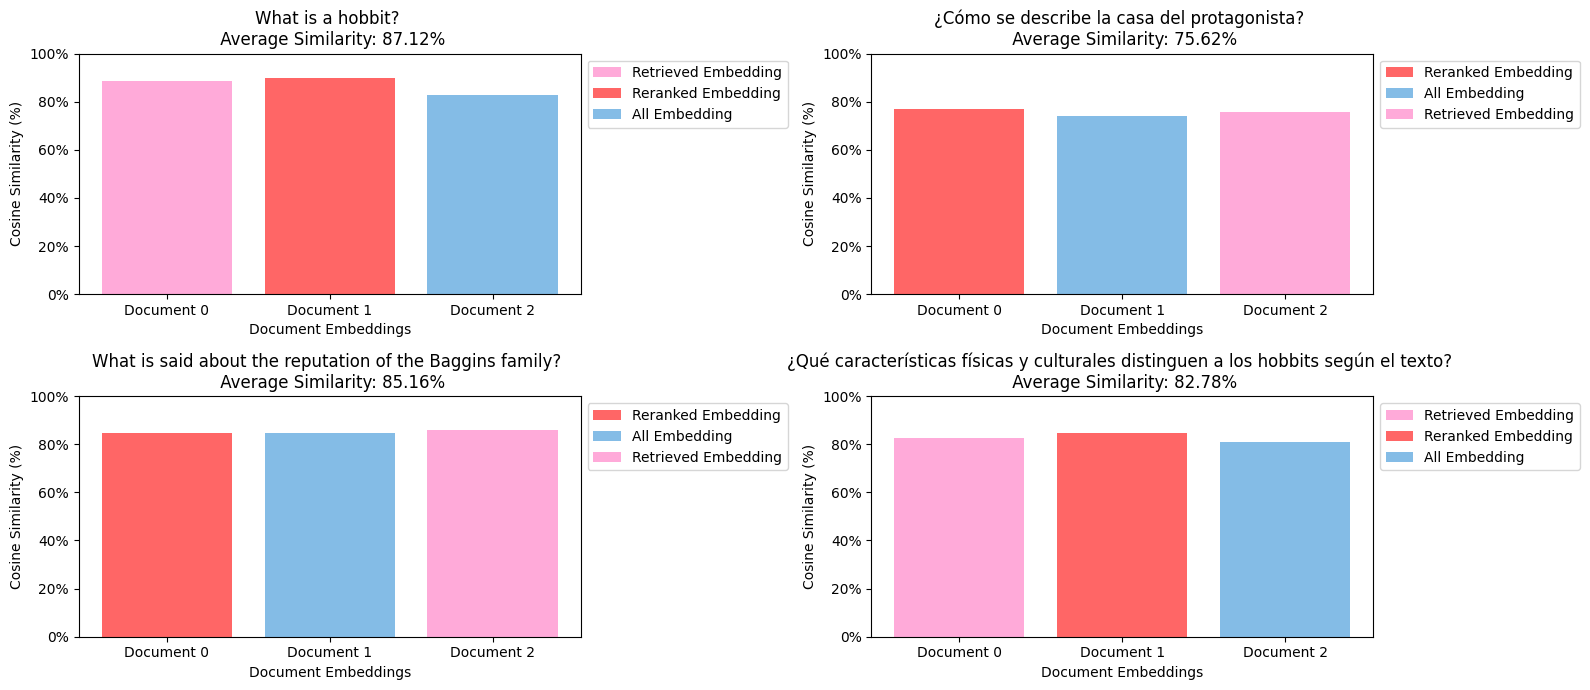

In [26]:
from ragatouille import RAGPretrainedModel
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Questions
user_queries = ["What is a hobbit?", "¿Cómo se describe la casa del protagonista?", "What is said about the reputation of the Baggins family?", "¿Qué características físicas y culturales distinguen a los hobbits según el texto?"]
user_vectors = [embedding_model.embed_query(user_query) for user_query in user_queries]

# Chroma documents
chroma_documents = KNOWLEDGE_VECTOR_DATABASE.get(include=['embeddings'])
chroma_vectors = chroma_documents['embeddings']

# Reranker
RERANKER = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

# Cosine similarity
cos = torch.nn.CosineSimilarity(dim=-1, eps=1e-6)

# Plots
fig, axs = plt.subplots(2, 2)
fig.set_figheight(7)
fig.set_figwidth(16)
for i, user_query in enumerate(user_queries):
    # Retrived documents
    retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=2)
    retrieved_content = [doc.page_content for doc in retrieved_docs]
    retrieved_vectors = [embedding_model.embed_query(doc.page_content) for doc in retrieved_docs]
    
    # Reranked documents
    reranked_docs = RERANKER.rerank(user_query, retrieved_content, k=1)
    reranked_content = [doc["content"] for doc in reranked_docs]
    reranked_vectors = [embedding_model.embed_query(doc["content"]) for doc in reranked_docs]

    # Cosine similarity
    cos_similarities = []
    for embedding in chroma_vectors:
        similarity = cos(torch.tensor(user_vectors[i]), torch.tensor(embedding))
        cos_similarities.append(similarity.item()*100)

    # Calculate mean similarity
    mean_similarity = sum(cos_similarities) / len(cos_similarities)
    
    # Create subplot
    ax = plt.subplot(2, 2, i+1)
    for a, embedding in enumerate(chroma_vectors):
        if embedding in reranked_vectors:
            label="Reranked Embedding"
            color="#FF6666"
        elif embedding in retrieved_vectors:
            label="Retrieved Embedding"
            color="#FFAAD9"
        else:
            label="All Embedding"
            color="#84BCE6"
        ax.bar(f"Document {a}", cos_similarities[a], label=label, color=color)
    ax.set_xlabel("Document Embeddings")
    ax.set_ylabel("Cosine Similarity (%)")
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d%%')) # Percentage format
    ax.set_title(f"{user_query} \n Average Similarity: {mean_similarity:.2f}%")
    plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')
    plt.ylim(0, 100)
plt.tight_layout()
plt.show()


### 2. Reader - LLM
The LLM Reader reads the retrieved context (the content of the retrieved documents) to formulate its answer. <br>
The context and the user query are aggregated into a prompt then given to the LLM to generate its answer.

#### 2.1. Reader model
<b>The reader model’s max_seq_length must accomodate our prompt</b> , which includes the context output by the retriever call: the context consists in 5 documents of 512 tokens each, so we aim for a context length of 4k tokens at least.<br><br>

In [5]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForCausalLM

READER_MODEL_NAME = "HuggingFaceH4/zephyr-7b-beta"
model = AutoModelForCausalLM.from_pretrained(READER_MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

#### 2.2. Prompt
The RAG prompt template below is what we will feed to the Reader LLM: it is important to have it formatted in the Reader LLM’s chat template.<br><br>

In [ ]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.""",
    },
    {
        "role": "user",
        "content": """Context:
{context}
---
Now here is the question you need to answer.

Question: {question}""",
    },
]
RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)
print(RAG_PROMPT_TEMPLATE)

#### 2.3 User question / RAG answer

In [ ]:
from ragatouille import RAGPretrainedModel
from transformers import Pipeline

RERANKER = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

def answer_with_rag(
    question: str,
    llm: Pipeline,
    knowledge_index: Chroma,
    reranker: Optional[RAGPretrainedModel] = None,
    num_retrieved_docs: int = 2,
    num_docs_final: int = 1,
) -> Tuple[str, List[LangchainDocument]]:
    # Gather documents with retriever
    print("=> Retrieving documents...")
    relevant_docs = knowledge_index.similarity_search(query=question, k=num_retrieved_docs)
    relevant_docs = [doc.page_content for doc in relevant_docs]  # keep only the text

    # Optionally rerank results
    if reranker:
        print("=> Reranking documents...")
        relevant_docs = reranker.rerank(question, relevant_docs, k=num_docs_final)
        relevant_docs = [doc["content"] for doc in relevant_docs]

    relevant_docs = relevant_docs[:num_docs_final]

    # Build the final prompt
    context = "\nExtracted documents:\n"
    context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs)])

    final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)

    # Redact an answer
    print("=> Generating answer...")
    answer = llm(final_prompt)[0]["generated_text"]

    return answer, relevant_docs

for user_query in user_queries:
    answer, relevant_docs = answer_with_rag(user_query, READER_LLM, KNOWLEDGE_VECTOR_DATABASE, reranker=RERANKER)
    print("==================================Answer==================================")
    print(f"{answer}")
    print("==================================Source docs==================================")
    for i, doc in enumerate(relevant_docs):
        print(f"Document {i}------------------------------------------------------------")
        print(doc)